# predict

### setup

In [15]:
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())

#Global vars
CV=4


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;

Configured for my local MIMIC database (modified tables):
	my_username = postgres
	my_dbname = mimic
	host = localhost
	my_schema_name = my_mimic_db
	my_schema = SET search_path to my_mimic_db;


## load sets

In [16]:
import joblib
X_train = joblib.load(open(my_local_data_dir + 'X_train.joblib', 'rb'))
y_train = joblib.load(open(my_local_data_dir + 'y_train.joblib', 'rb'))
X_test = joblib.load(open(my_local_data_dir + 'X_test.joblib', 'rb'))
y_test = joblib.load(open(my_local_data_dir + 'y_test.joblib', 'rb'))
print(X_train.shape)
print(len(y_train))
print(np.sum(y_train))
print(X_test.shape)
print(len(y_test))
print(np.sum(y_test))

(35164, 294)
35164
1724
(8792, 294)
8792
431


## Handle imballanced data using SMOTE

In [17]:
from collections import Counter
from imblearn.over_sampling import SMOTE
counter = Counter(y_train)
print(counter)
pct=round(counter[1]/len(y_train), 3)*100
print('starting positive rate = {}%'.format(pct))
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
counter = Counter(y_train_sm)
print(counter)
pct=round(counter[1]/len(y_train_sm), 3)*100
print('after SMOTE positive rate = {}%'.format(pct))

Counter({0: 33440, 1: 1724})
starting positive rate = 4.9%
Counter({0: 33440, 1: 33440})
after SMOTE positive rate = 50.0%


### set the SMOTE set as traning set

In [18]:
X_train = X_train_sm
y_train = y_train_sm
X_train.shape

(66880, 294)

### train logistic regression

In [19]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
log_reg = LogisticRegressionCV(max_iter=1000,
#                                solver='liblinear',
                                 scoring='recall',
                               n_jobs=4)

#train
log_reg.fit(X_train, y_train)

LogisticRegressionCV(max_iter=1000, n_jobs=4, scoring='recall')

### logistic regression cross validation performance

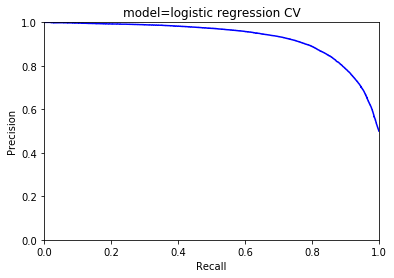

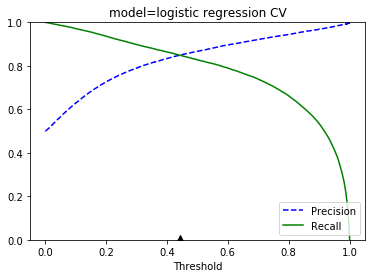

Confusion matrix for threshold = 0.44:
[[28388  5052]
 [ 5053 28387]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     33440
           1       0.85      0.85      0.85     33440

    accuracy                           0.85     66880
   macro avg       0.85      0.85      0.85     66880
weighted avg       0.85      0.85      0.85     66880



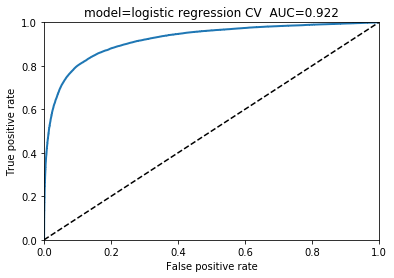

In [20]:
#logistic regression cross validation
probs_log_cv = cross_val_predict(log_reg, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_log_cv = probs_log_cv[:, 1]
log_perf_cv = get_model_performance('logistic regression CV', X_train, scores_log_cv, y_train, pos_label=1)

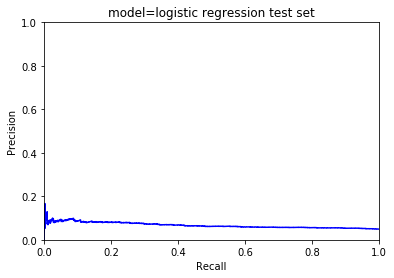

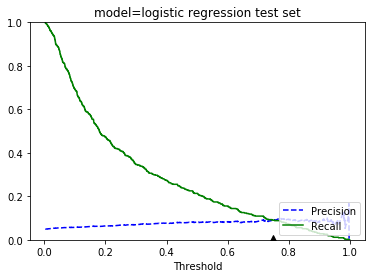

Confusion matrix for threshold = 0.75:
[[7970  391]
 [ 392   39]]
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8361
           1       0.09      0.09      0.09       431

    accuracy                           0.91      8792
   macro avg       0.52      0.52      0.52      8792
weighted avg       0.91      0.91      0.91      8792



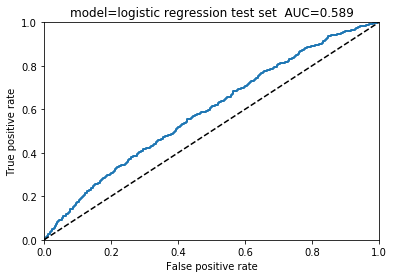

In [21]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

## Random forest

In [22]:
#------- OPTIMIZE RF
RAND_SEED=321
N_JOBS=3
#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [10,20,30,40]
min_samples_split = [2]
min_samples_leaf = [1]
max_features = ["auto", "sqrt"]
max_samples = [int(X_train.shape[0]*0.25),
              int(X_train.shape[0]*0.5),
              int(X_train.shape[0]*0.75),
              int(X_train.shape[0])]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'max_samples': max_samples}


# ### run random search
print('Random grid:')
print(random_grid)
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'recall',
                               cv = 4,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = N_JOBS)
rf_search.fit(X_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)


Random grid:
{'max_depth': [10, 20, 30, 40], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': ['auto', 'sqrt'], 'max_samples': [16720, 33440, 50160, 66880]}
Fitting 4 folds for each of 32 candidates, totalling 128 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.1min
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done 128 out of 128 | elapsed:  5.8min finished


{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 33440, 'max_features': 'sqrt', 'max_depth': 40}


In [31]:
best_params = {'min_samples_split': 2,
               'min_samples_leaf': 1,
               'max_samples': 50160,
               'max_features': 'sqrt',
               'max_depth': 30}

In [32]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 50160, 'max_features': 'sqrt', 'max_depth': 30}


RandomForestClassifier(max_depth=30, n_jobs=3, random_state=321)

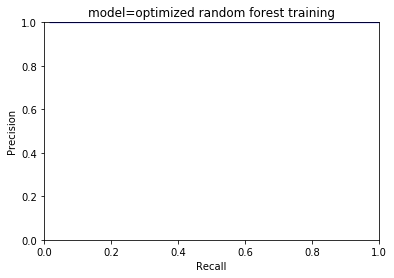

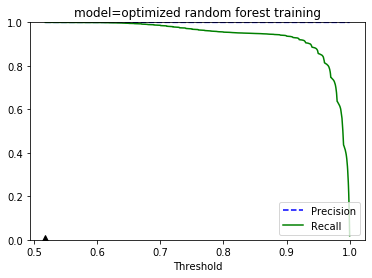

Confusion matrix for threshold = 0.52:
[[33440     0]
 [    1 33439]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33440
           1       1.00      1.00      1.00     33440

    accuracy                           1.00     66880
   macro avg       1.00      1.00      1.00     66880
weighted avg       1.00      1.00      1.00     66880



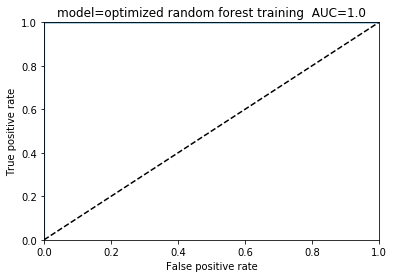

In [33]:
#optimized model performance on training set
scores_opt = rf_opt.predict_proba(X_train)[:, 1]
opt_perf = get_model_performance('optimized random forest training', X_train, scores_opt, y_train, pos_label=1)

### random forest cross validation performance

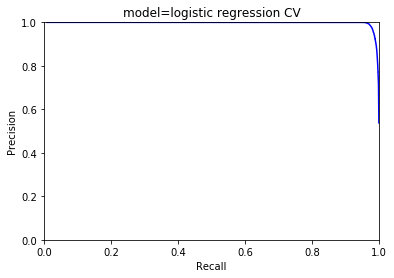

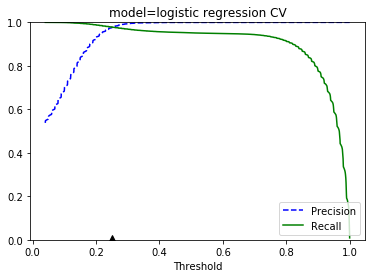

Confusion matrix for threshold = 0.25:
[[32692   748]
 [  749 32691]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     33440
           1       0.98      0.98      0.98     33440

    accuracy                           0.98     66880
   macro avg       0.98      0.98      0.98     66880
weighted avg       0.98      0.98      0.98     66880



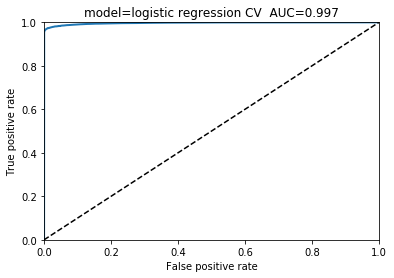

0.997


In [34]:
#logistic regression cross validation
probs_rf_cv = cross_val_predict(rf_opt, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_rf_cv = probs_rf_cv[:, 1]
rf_perf_cv = get_model_performance('logistic regression CV', X_train, scores_rf_cv, y_train, pos_label=1)
print(rf_perf_cv['auc'])

### plot AUC from the two cross validations

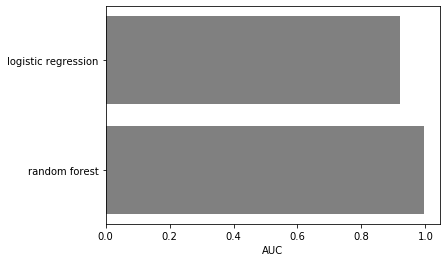

In [35]:
mods = ['logistic regression',
       'random forest']
performance = [log_perf_cv['auc'],
               rf_perf_cv['auc']]
fig, ax = plt.subplots()
y_pos = np.arange(len(mods))
ax.barh(y_pos, performance, align='center', color='grey')
ax.set_yticks(y_pos)
ax.set_yticklabels(mods)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('AUC')
plt.show()
auc_df = pd.DataFrame({'model':mods, 'auc':performance})
auc_df.to_csv('../data/for_plotting/auc_comparison.csv', index=False)

### performance on test set

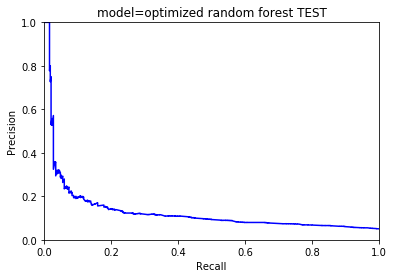

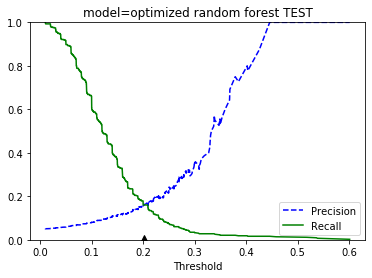

Confusion matrix for threshold = 0.2:
[[8000  361]
 [ 362   69]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8361
           1       0.16      0.16      0.16       431

    accuracy                           0.92      8792
   macro avg       0.56      0.56      0.56      8792
weighted avg       0.92      0.92      0.92      8792



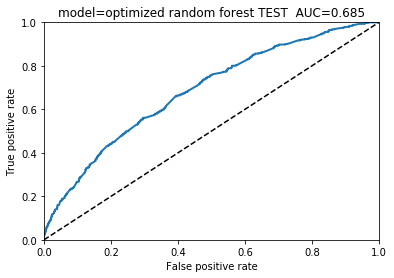

Confusion matrix for threshold = 0.13:
[[6394 1967]
 [ 222  209]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      8361
           1       0.10      0.48      0.16       431

    accuracy                           0.75      8792
   macro avg       0.53      0.62      0.51      8792
weighted avg       0.92      0.75      0.82      8792



['../data/for_app/performance.joblib']

In [36]:
#predict for test set
exec(open("my_functions.py").read())
test_scores = rf_opt.predict_proba(X_test)[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.128
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))
joblib.dump(test_perf, '../data/for_app/performance.joblib')

In [45]:
perf_out = pd.DataFrame({'fpr':test_perf['fpr'],
                       'tpr': test_perf['tpr'],
                       'auc' : test_perf['auc']})
perf_out.to_csv('../data/for_plotting/auc_curve.csv', index=False)

### get importance

In [62]:
importances = rf_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_opt.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = X_test.columns[indices]
idat = pd.DataFrame({'feature':features,
                     'importance': importances,
                   'std': std,
                   'index':indices})
idat = idat.sort_values('importance', ascending=False)
print(idat.shape)
idat

(294, 4)


,feature,importance,std,index
34,DNword_prednisone,0.021298,0.024241,266
269,diagnosis_icd9_42822,0.020678,0.027138,51
187,diagnosis_icd9_V4581,0.018813,0.027004,87
106,drug_LR,0.017475,0.016128,167
110,procedure_icd9_9671,0.016679,0.017750,103
...,...,...,...,...
83,drug_Fentanyl Citrate,0.000397,0.000394,145
39,diagnosis_icd9_41401,0.000390,0.000333,42
276,drug_Meropenem,0.000370,0.000284,177
90,last_wardid_23,0.000298,0.000309,241


### add back in the diagnosis names

In [63]:
query = query_schema + \
"""select 
    *
    from D_ICD_DIAGNOSES"""
ddat = pd.read_sql_query(query,con)
ddat['feature'] = ['diagnosis_icd9_' + x for x in ddat['icd9_code']]
idat_out = pd.merge(idat, ddat, how = 'left', on = 'feature')
idat_out.loc[idat_out['short_title'].notna(), 'feature'] = idat_out['short_title'] 
print(idat_out.shape)
idat_out

(294, 8)


,feature,importance,std,index,row_id,icd9_code,short_title,long_title
0,DNword_prednisone,0.021298,0.024241,266,NaN,NaN,NaN,NaN
1,Chr systolic hrt failure,0.020678,0.027138,51,4477.0,42822,Chr systolic hrt failure,Chronic systolic heart failure
2,Aortocoronary bypass,0.018813,0.027004,87,10140.0,V4581,Aortocoronary bypass,Aortocoronary bypass status
3,drug_LR,0.017475,0.016128,167,NaN,NaN,NaN,NaN
4,procedure_icd9_9671,0.016679,0.017750,103,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
289,drug_Fentanyl Citrate,0.000397,0.000394,145,NaN,NaN,NaN,NaN
290,Crnry athrscl natve vssl,0.000390,0.000333,42,4374.0,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
291,drug_Meropenem,0.000370,0.000284,177,NaN,NaN,NaN,NaN
292,last_wardid_23,0.000298,0.000309,241,NaN,NaN,NaN,NaN


### save for app

In [64]:
import joblib
joblib.dump(idat_out.loc[idat_out['importance']>0.0,:], '../data/for_app/importances.joblib');